# 1. Preprocess dataset 

In [3]:
import csv
import re

from collections import Counter
from gensim.models import Word2Vec
from random import random
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from torch import nn
from torch.autograd import Variable

import numpy as np
import torch
import torch.nn.functional as F

In [4]:
train_emotion = []
train_tweets = []
with open('dataset/train.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"', skipinitialspace=True)
    line_count = 0
    for row in spamreader:
        line_count += 1
        if line_count == 1: continue # skip header
        if not row: continue
        emotion = row[0]
        tweet = row[1]
        tweet = tweet.replace('@USERNAME', '')
        tweet = tweet.replace('[#TRIGGERWORD#]', '')
        tweet = result = re.sub(r"http\S+", "", tweet)
        train_tweets.append(tweet)
        train_emotion.append(emotion)

In [5]:
sentences = train_tweets

# Lower-case the sentence, tokenize them and add <SOS> and <EOS> tokens
sentences = [["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] for sentence in sentences]

# Create the vocabulary. Note that we add an <UNK> token to represent words not in our vocabulary.
word_counts = Counter([word for sentence in sentences for word in sentence])
vocabulary = ["<UNK>"] + [e[0] for e in list(word_counts.items()) if e[1] > 2]
vocabularySize = len(vocabulary)
word2index = {word:index for index,word in enumerate(vocabulary)}
one_hot_embeddings = np.eye(vocabularySize)

In [6]:
# Create emotion array
emotions = sorted(list(set(train_emotion)))
emotions

['anger', 'disgust', 'fear', 'joy', 'sad', 'surprise']

In [7]:
# Build the word2vec embeddings
wordEncodingSize = 300
filtered_sentences = [[word for word in sentence if word in word2index] for sentence in sentences]
w2v = Word2Vec(filtered_sentences, min_count=0, size=wordEncodingSize)
w2v_embeddings = np.concatenate((np.zeros((1, wordEncodingSize)), w2v.wv.syn0))

/Users/Danielz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """


In [8]:
def preprocess_numberize(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into list of numbers (denoting the index into the vocabulary).
    """
    tokenized = word_tokenize(sentence.lower())
        
    # Add the <SOS>/<EOS> tokens and numberize (all unknown words are represented as <UNK>).
    tokenized = ["<SOS>"] + tokenized + ["<EOS>"]
    numberized = [word2index.get(word, 0) for word in tokenized]
    
    return numberized

def preprocess_one_hot(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of one-hot vectors.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    one_hot_embedded = one_hot_embeddings[numberized]
    
    return one_hot_embedded

def preprocess_word2vec(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of word2vec embeddings.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    w2v_embedded = w2v_embeddings[numberized]
    
    return w2v_embedded

def compute_bleu(reference_sentence, predicted_sentence):
    """
    Given a reference sentence, and a predicted sentence, compute the BLEU similary between them.
    """
    reference_tokenized = word_tokenize(reference_sentence.lower())
    predicted_tokenized = word_tokenize(predicted_sentence.lower())
    return sentence_bleu([reference_tokenized], predicted_tokenized)

# 1. Build a Emotion Decoder

In [9]:
use_cuda = False
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional = True)
        self.out = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input, hidden):
        output = F.relu(input)
        output, hidden = self.lstm(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1) 
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(2, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
'''
# decoder for one hot embedding
decoder=DecoderLSTM(input_size=len(vocabulary), 
                    hidden_size=300, 
                    output_size=len(emotions))
'''
# decoder for word2vec embedding
decoder=DecoderLSTM(input_size=wordEncodingSize, 
                    hidden_size=300, 
                    output_size=len(emotions))
decoder

DecoderLSTM(
  (lstm): LSTM(300, 300, bidirectional=True)
  (out): Linear(in_features=600, out_features=6)
)

# 2. Train the Emotion Decoder

In [10]:
# build some helper function
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [12]:
def train(target_variable, 
          emotion,
          decoder, 
          decoder_optimizer, 
          criterion, 
          embeddings=w2v_embeddings,
          teacher_force=True): 
    """
    Given a single training sample, go through a single step of training.
    """
    loss = 0
    decoder_optimizer.zero_grad()
    
    decoder_input = Variable(torch.FloatTensor([[embeddings[target_variable[0].data[0]]]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoder_hidden = (decoder.initHidden(), decoder.initHidden())

    for di in range(0,target_variable.size(0)):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)

        if teacher_force:
            ni = target_variable[di].data[0]
        else:          
            ni = topi[0][0]
        
        decoder_input = Variable(torch.FloatTensor([[embeddings[ni]]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        if di == target_variable.size(0) - 2: 
            loss += criterion(decoder_output, emotion)
        if vocabulary[ni] == "<EOS>":
            break

    loss.backward()
    
    torch.nn.utils.clip_grad_norm(decoder.parameters(), 10.0)

    decoder_optimizer.step()

    return loss.data[0] / target_variable.size(0)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()  

num_epochs = 1
numberized_emotion = [emotions.index(emotion) for emotion in train_emotion]
target_emotion = Variable(torch.LongTensor(numberized_emotion))
start = time.time()
total_loss = 0
avg_loss = []
for _ in range(num_epochs):
    for i,sentence in enumerate(train_tweets):
        
        numberized = preprocess_numberize(sentence)
        if len(numberized) == 2:
            continue
        target_variable = Variable(torch.LongTensor(numberized[1:]))

        loss = train(target_variable, target_emotion[i], decoder, decoder_optimizer, criterion)
        total_loss += loss
        avg_loss.append(total_loss/(i+1))
        if i % 1000 == 0:
            print('%s (%d %d%%) %.6f' % 
                  (timeSince(start, (i+1)/len(train_tweets)), i, (i+1)/len(train_tweets)*100, total_loss/(i+1)))

0m 0s (- 241m 1s) (0 0%) 0.116944
2m 8s (- 325m 59s) (1000 0%) 0.100448
4m 12s (- 318m 6s) (2000 1%) 0.101228
6m 19s (- 316m 33s) (3000 1%) 0.100458
8m 26s (- 315m 3s) (4000 2%) 0.100014
10m 42s (- 317m 43s) (5000 3%) 0.100137
12m 49s (- 314m 42s) (6000 3%) 0.099651
15m 1s (- 313m 47s) (7000 4%) 0.099481
17m 8s (- 311m 15s) (8000 5%) 0.099472
19m 16s (- 308m 55s) (9000 5%) 0.099702
22m 51s (- 327m 27s) (10000 6%) 0.099324
28m 32s (- 369m 9s) (11000 7%) 0.098921
35m 32s (- 418m 28s) (12000 7%) 0.098664
41m 19s (- 445m 54s) (13000 8%) 0.098236
46m 42s (- 464m 43s) (14000 9%) 0.097801
52m 14s (- 481m 30s) (15000 9%) 0.097469
58m 31s (- 502m 10s) (16000 10%) 0.097176
64m 3s (- 513m 27s) (17000 11%) 0.096916
69m 46s (- 524m 20s) (18000 11%) 0.096751
75m 53s (- 536m 20s) (19000 12%) 0.096371
81m 50s (- 545m 20s) (20000 13%) 0.096017
87m 19s (- 550m 2s) (21000 13%) 0.095716
91m 54s (- 548m 25s) (22000 14%) 0.095503
96m 39s (- 547m 28s) (23000 15%) 0.095167
101m 21s (- 546m 1s) (24000 15%) 0.0

In [50]:
len(train_tweets)
showPlot(avg_loss)

In [18]:
# after training, save model 
torch.save(decoder.state_dict(), 'decoder2ep001lrbiLSTM.pt')

In [33]:
# load previously training model:
decoder.load_state_dict(torch.load('decoder2ep001lrbiLSTM.pt'))
# torch.load(decoder.load_state_dict(), ('decoder_lr0.001.pt'))

# 3. Evaluate the Emotion decoder

In [14]:
dev_tweets = []

print(sum(1 for line in open('dataset/dev.csv')))

with open('dataset/dev.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"', skipinitialspace=True, quoting=csv.QUOTE_NONE)
    line_count = 0
    for row in spamreader:
        line_count += 1
        if line_count == 1: continue # skip header
        if not row: 
            continue
        tweet = row[1]
        tweet = tweet.replace('@USERNAME', '')
        tweet = tweet.replace('[#TRIGGERWORD#]', '')
        tweet = result = re.sub(r"http\S+", "", tweet)
        dev_tweets.append(tweet)
print(len(dev_tweets))

9592
9591


In [15]:
dev_emotions = []
with open('dataset/trial-v3.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"', skipinitialspace=True)
    line_count = 0
    for row in spamreader:
        line_count += 1
        if line_count == 1: continue # skip header
        if not row: continue
        dev_emotions.append(row[0])

In [128]:
actual_result = []
def evaluate(decoder, 
             target_variable, 
             embeddings=w2v_embeddings, 
             teacher_force=True):
    
    decoder_input = Variable(torch.FloatTensor([[embeddings[target_variable[0].data[0]]]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoder_hidden = (decoder.initHidden(),decoder.initHidden())
    
    softmax = nn.Softmax()
    for di in range(0,target_variable.size(0)):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        
        if teacher_force:
            ni = target_variable[di].data[0]
        else:          
            ni = topi[0][0]

        decoder_input = Variable(torch.FloatTensor([[embeddings[ni]]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        if di == target_variable.size(0) - 2: # last output 
            actual_result.append(emotions[topi[0][0]])
            if dev_emotions[i] == emotions[topi[0][0]]:
                return True
            #print (dev_emotions[i], emotions[topi[0][0]])
            
        if vocabulary[ni] == "<EOS>":
            break
    return False

# evaluate the model
print ("ground truth, model prediction")
correct_prediction_counts = 0
for i,tweet in enumerate(dev_tweets): 
    numberized = preprocess_numberize(tweet)
    if len(numberized) == 2: continue
    target_variable = Variable(torch.LongTensor(numberized[1:]))
    
    if evaluate(decoder, target_variable):
        correct_prediction_counts += 1
    
    if i % 100 == 0:
        print (correct_prediction_counts, " correct predictions in ", i+1)
        print ("acurray: ", correct_prediction_counts/(i+1))


ground truth, model prediction
1  correct predictions in  1
acurray:  1.0
42  correct predictions in  101
acurray:  0.4158415841584158
86  correct predictions in  201
acurray:  0.42786069651741293
126  correct predictions in  301
acurray:  0.4186046511627907
166  correct predictions in  401
acurray:  0.4139650872817955
210  correct predictions in  501
acurray:  0.41916167664670656
246  correct predictions in  601
acurray:  0.40931780366056575
293  correct predictions in  701
acurray:  0.41797432239657634
337  correct predictions in  801
acurray:  0.4207240948813982
370  correct predictions in  901
acurray:  0.41065482796892344
409  correct predictions in  1001
acurray:  0.4085914085914086
450  correct predictions in  1101
acurray:  0.4087193460490463
483  correct predictions in  1201
acurray:  0.4021648626144879
525  correct predictions in  1301
acurray:  0.4035357417371253
573  correct predictions in  1401
acurray:  0.4089935760171306
619  correct predictions in  1501
acurray:  0.4123

Labels: sad;disgust;joy;anger;surprise;fear
Label	TP	FP	FN	P	R	F
sad	345	276	1115	0.556	0.236	0.332
disgust	605	667	992	0.476	0.379	0.422
joy	786	373	950	0.678	0.453	0.543
anger	452	756	1148	0.374	0.282	0.322
surpris	950	2131	650	0.308	0.594	0.406
fear	825	1425	773	0.367	0.516	0.429
MicAvg	3963	5628	5628	0.413	0.413	0.413
MacAvg				0.46	0.41	0.409
Official result: 0.4088256594362334


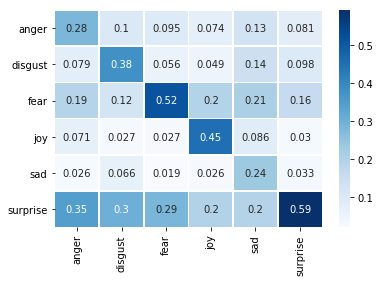

[-1.60058284 -2.88473797 -1.67497349 -3.39446735 -0.90067869 -2.16120434]
['anger', 'disgust', 'fear', 'joy', 'sad', 'surprise']
[0 1 2 3 4 5]
[0.12686279740700729, 0.22864541575807415, 0.13275902827340466, 0.26904675845133408, 0.071388131873148963, 0.17129786823703086]


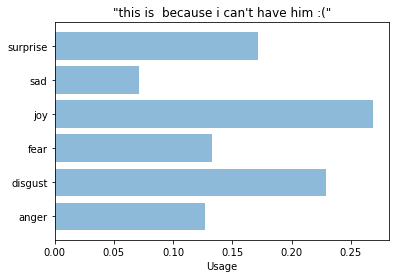

[-1.49632537 -2.5358398  -1.81656289 -2.45840192 -1.71923625 -1.31120515]
['anger', 'disgust', 'fear', 'joy', 'sad', 'surprise']
[0 1 2 3 4 5]
[0.13197935635106611, 0.22366693099506341, 0.16022504553371894, 0.21683673120691446, 0.15164061126374595, 0.11565132464949114]


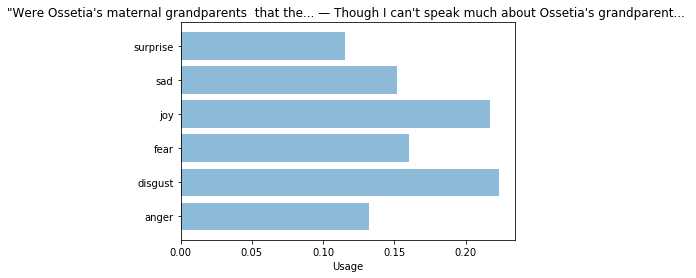

[-1.43432081 -2.06905603 -1.87586713 -1.93400657 -2.5277493  -1.35561168]
['anger', 'disgust', 'fear', 'joy', 'sad', 'surprise']
[0 1 2 3 4 5]
[0.12810311444941352, 0.18479305365929694, 0.1675388240820489, 0.17273141679412346, 0.22576020384995377, 0.1210733871651634]


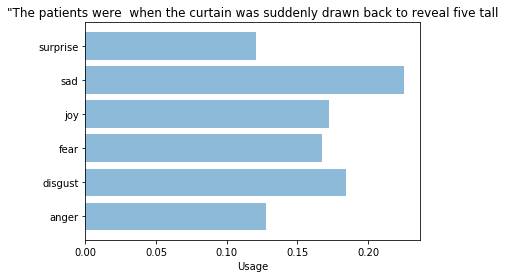

In [188]:
#!/usr/bin/env python
# Author: roman.klinger@ims.uni-stuttgart.de
# Evaluation script for IEST at WASSA 2018
from __future__ import print_function
import sys
import itertools
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import random
from matplotlib.widgets import Slider, Button, RadioButtons

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

def welcome():
    eprint("====================================")
    eprint("Evaluation script v0.2 for the Implicit Emotions Shared Task 2018.")
    eprint("Please call it via")
    eprint("./evaluate-iest.py <gold> <prediction>")
    eprint("where each csv file has labels in its first column.")
    eprint("The rows correspond to each other (1st row in <gold>")
    eprint("is the gold label for the 1st column in <prediction>).")
    eprint("")
    eprint("If you have questions, please contact klinger@wassa2018.com")
    eprint("====================================\n\n")

def checkParameters():
    if ((len(sys.argv) < 3 or len(sys.argv) > 3)):
        eprint("Please call the script with two files as parameters.")
        sys.exit(1)

def readFileToList(filename):
    eprint("Reading data from",filename)
    f=open(filename,"r")
    lines=f.readlines()
    result=[]
    for x in lines:
        result.append(x.split('\t')[0].rstrip())
    f.close()
    eprint("Read",len(result),"labels.")
    return result

def calculatePRF(gold,prediction):
    # initialize counters
    labels = set(gold+prediction)
    print("Labels: "+';'.join(labels))
    tp = dict.fromkeys(labels, 0.0)
    fp = dict.fromkeys(labels, 0.0)
    fn = dict.fromkeys(labels, 0.0)
    precision = dict.fromkeys(labels, 0.0)
    recall = dict.fromkeys(labels, 0.0)
    f = dict.fromkeys(labels, 0.0)
    # check every element
    for g,p in zip(gold,prediction):
        #        print(g,p)
        # TP 
        if (g == p):
            tp[g] += 1
        else:
            fp[p] += 1
            fn[g] += 1
    # print stats
    print("Label\tTP\tFP\tFN\tP\tR\tF")
    for label in labels:
        recall[label] = 0.0 if (tp[label]+fn[label]) == 0.0 else (tp[label])/(tp[label]+fn[label])
        precision[label] = 1.0 if (tp[label]+fp[label]) == 0.0 else (tp[label])/(tp[label]+fp[label])
        f[label] = 0.0 if (precision[label]+recall[label])==0 else (2*precision[label]*recall[label])/(precision[label]+recall[label])
        print(label[:7]+
            "\t"+str(int(tp[label]))+
            "\t"+str(int(fp[label]))+
            "\t"+str(int(fn[label]))+
            "\t"+str(round(precision[label],3))+
            "\t"+str(round(recall[label],3))+
            "\t"+str(round(f[label],3))
            )
        # micro average
        microrecall = (sum(tp.values()))/(sum(tp.values())+sum(fn.values()))
        microprecision = (sum(tp.values()))/(sum(tp.values())+sum(fp.values()))
        microf = 0.0 if (microprecision+microrecall)==0 else (2*microprecision*microrecall)/(microprecision+microrecall)
    # Micro average
    print("MicAvg"+
        "\t"+str(int(sum(tp.values())))+
        "\t"+str(int(sum(fp.values())))+
        "\t"+str(int(sum(fn.values())))+
        "\t"+str(round(microprecision,3))+
        "\t"+str(round(microrecall,3))+
        "\t"+str(round(microf,3))
        )
    # Macro average
    macrorecall = sum(recall.values())/len(recall)
    macroprecision = sum(precision.values())/len(precision)
    macroF = sum(f.values())/len(f)
    print("MacAvg"+
        "\t"+str( )+
        "\t"+str( )+
        "\t"+str( )+
        "\t"+str(round(macroprecision,3))+
        "\t"+str(round(macrorecall,3))+
        "\t"+str(round(macroF,3))
        )
    print("Official result:",macroF)
        
if (len(actual_result) != len(dev_emotions)):
    eprint("Number of labels is not aligned!")
    sys.exit(1)
calculatePRF(dev_emotions,actual_result)

percent_matrix = [[0 for col in range(6)] for row in range(6)]
for i in range(len(dev_emotions)):
    percent_matrix[emotions.index(dev_emotions[i])][emotions.index(actual_result[i])] += 1

dim_matrix = len(percent_matrix)
col_sum = [0] * len(emotions)
for i in range(dim_matrix):
    for j in range(dim_matrix):
        col_sum[i] = col_sum[i] + percent_matrix[i][j]
        
for i in range(len(percent_matrix)):
    for j in range(len(percent_matrix)):
        percent_matrix[i][j] = percent_matrix[i][j] / col_sum[i]
        
percent_matrix=pd.DataFrame(percent_matrix, columns = emotions, index = emotions)
# display(HTML(percent_matrix.to_html()))

# plot heatmap
ax = sns.heatmap(percent_matrix.T, annot=True, linewidths=.5, cmap="Blues")

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.savefig('resultHeatmap.png', dpi=100)
plt.show()

def convertPercentage(numList):
    summ = 0
    percent = []
    for num in numList:
        summ += num
    for i in range(len(numList)):
        percent.append(numList[i]/summ)
    return percent

def drawBar(percentList, title):
    y_pos = np.arange(len(emotions))
    print(emotions)
    print(y_pos)
    print(percentList)
    plt.barh(y_pos, percentList, align='center', alpha=0.5)
    plt.yticks(y_pos, emotions)
    plt.xlabel('Usage')
    plt.title(title)
 
    plt.show()
def test_sample_output(sentences):
    teacher_force = True

    for i,tweet in enumerate(sentences): 
        numberized = preprocess_numberize(tweet)
        if len(numberized) == 2: continue
        target_variable = Variable(torch.LongTensor(numberized[1:]))
        decoder_input = Variable(torch.FloatTensor([[w2v_embeddings[target_variable[0].data[0]]]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        decoder_hidden = (decoder.initHidden(),decoder.initHidden())

        softmax = nn.Softmax()
        for di in range(0,target_variable.size(0)):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)

            if teacher_force:
                ni = target_variable[di].data[0]
            else:          
                ni = topi[0][0]

            decoder_input = Variable(torch.FloatTensor([[w2v_embeddings[ni]]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            if di == target_variable.size(0) - 2: # last output 
                tmp_output = decoder_output.data.cpu().numpy()[0]
                print(tmp_output)
                tmp_output = convertPercentage(tmp_output)
                drawBar(tmp_output, tweet)

samples = random.sample(range(0,9501), 3)
test_sentences = [dev_tweets[i] for i in samples]
test_sample_output(test_sentences)


<class 'list'>
<class 'list'>
<class 'str'>
<class 'str'>
